In [1]:
"""Program that contains a Genetic Algorithm class

The program also solves three problems: guessing a word, converting a decimal number to binary, and the N queen problem.
"""
import random
from random import choice
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import string
from copy import deepcopy


class GeneticAlgorithm:
    """Creates a generic Genetic Algorithm class.

    Attributes:
        fitness: The fitness function of the problem.
        individual_factory: Function that creates an individual.
        termination_condition: Condition to terminate the Genetic Algorithm process in terms of the fitness.
        max_iter: Integer indicating the maximum number of generations to create.
        pop_size: Integer indicating the population size of all the generations.
        mutation_rate: Float representing the probability to apply mutation over an individual.
        silent: Boolean that dictaminates wether to print or not all the extra information about the process.
        negative_maximization: Boolean referring to the type of maximization (if it has negatives values or don't).
        worst_fitness: Integer representing the worst fitness expected of an individual.
        legible_result: Boolean indicating wether to print or not the output in a legible way as a string.
        problem_name: String representing the problem to resolve. It is only used for saving the plots.
    """
    
    def __init__(self, fitness, individual_factory, max_iter, termination_condition, terminal_set, function_set, max_depth, problem_name, pop_size=100, mutation_rate=0.2, silent=False, negative_maximization=False, legible_result=False, offspring=1):
        """Inits GeneticAlgorithm."""
        assert offspring == 1 or offspring == 2, 'Offspring must be either 1 or 2'
        self.fitness = fitness
        self.individual_factory = individual_factory
        self.termination_condition = termination_condition
        self.max_iter = max_iter
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.silent = silent
        self.worst_fitness = - sys.maxsize - 1 if negative_maximization else 0
        self.legible_result = legible_result
        self.terminal_set = terminal_set
        self.function_set = function_set
        self.max_depth = max_depth
        self.problem_name = problem_name
        self.offspring = offspring

    def generate_population(self):
        """Generates the first generation population.
        
        Returns:
            A list containing all the individuals of a generation.
        """
        population = []
        for i in range(self.pop_size):
            individual = self.individual_factory(self.terminal_set, self.function_set, self.max_depth)
            population.append(individual)
        return population
    
    def select_individual(self, population):
        """Selects an individual for the crossover.

        It chooses the individual through the Tennis Tournament algorithm, picking 5 random
        individuals, and choosing the one with the highest fitness score.

        Args:
            population: All the population of the current generation.

        Returns:
            The individual selected.
        """
        n = len(population) - 1
        random_individuals = []
        max_individual = 0
        best_fitness = self.worst_fitness
        for i in range(5):
            j = random.randint(0, n)
            p = population[j]
            individual_fitness = self.fitness(p)
            if individual_fitness >= best_fitness:
                max_individual = p
                best_fitness = individual_fitness
        return max_individual
    
    def cross_over(self, parent_1, parent_2, offspring=1):
        """Performs the crossover between the two parents.

        After the crossover is performed, a mutation could be applied depending on a random number

        Args:
            parent_1: First parent.
            parent_2: Second parent.
        
        Returns:
            Child that results from the crossover of the two parents.
        """
        child_1 = parent_1.cross_over(parent_2)
        child_2 = parent_2.cross_over(parent_1)
     
        if np.random.rand() <= self.mutation_rate:
            child_1 = child_1.mutate()
        if np.random.rand() <= self.mutation_rate:
            child_2 = child_2.mutate()
        
        if offspring == 1:
            return child_1

        return child_1, child_2

           
    def evaluate_fitness(self, population):
        """Evaluates the fitness of all the population individually.

        Args:
            population: All the population of the current generation.

        Returns:
            For the current generation, a list with the fitness of each individual, the average of all the fitness,
            the individual with the best fitness score, the best fitness score, and the worst fitness score.
        """
        best_fitness = self.worst_fitness
        best_individual = None
        fitness_list = []
        for individual in population:
            fitness = self.fitness(individual)
            if fitness >= best_fitness:
                best_fitness = fitness
                best_individual = individual
            fitness_list.append(fitness)
        average_fitness = np.average(np.array(fitness_list))
        worst_fitness = min(fitness_list)
        return fitness_list, average_fitness, best_individual, best_fitness, worst_fitness
    
    def plot_results(self, best_fitness, avg_fitness, worst_fitness):
        """Plots the complete performance of the Genetic Algorithm.
        
        Args:
            best_fitness: List of integers representing the best fitness score of each generation.
            avg_fitness: List of floats representing the average fitness score of each generation.
            worst_fitness: List of integers representing the worst fitness score of each generation.
        """
        f1 = plt.figure(1, figsize=(10,7))
        ax1 = f1.add_subplot(111)
        ax1.set_title("Fitness v/s Generation")    
        ax1.set_xlabel('generation')
        ax1.set_ylabel('fitness')
        ax1.set_yscale('symlog')
        ax1.plot(best_fitness, c='steelblue', label='Best')
        ax1.plot(avg_fitness, '--', c='darkorange', label='Avg')
        ax1.plot(worst_fitness, '--', c='r', label='Worst')
        ax1.set_yscale('symlog')
        ax1.legend()
        f1.show()
        plt.savefig(self.problem_name, bbox_inches='tight')
        
    def run(self):
        """Runs the Genetic Algorithm."""
        population = self.generate_population()
        worst_fitness = self.worst_fitness
        iteration = 0
        best_fitness_list = []
        avg_fitness_list = []
        worst_fitness_list = []
        best_individual_so_far = None
        while(iteration <= self.max_iter):
            if not self.silent:
                print("Generation: ", iteration)
            fitness_list, avg_fitness, best_individual, best_fitness, worst_fitness = self.evaluate_fitness(population)
            if best_fitness >= worst_fitness:
                best_individual_so_far = best_individual
            best_fitness_list.append(best_fitness)
            avg_fitness_list.append(avg_fitness)
            worst_fitness_list.append(worst_fitness)
            if not self.silent:
                print("Best fitness this generation: ", best_fitness)
            if self.termination_condition(best_fitness):
                self.plot_results(best_fitness_list, avg_fitness_list, worst_fitness_list) if iteration > 0 else print("Found on first generation. No plot generated.")
                print("Found solution: {}".format(best_individual.tree.print_node()))
                return
            new_generation = []
            while len(new_generation) < self.pop_size:
                children = self.cross_over(self.select_individual(population), self.select_individual(population), self.offspring)
                if self.offspring == 2:
                    new_generation.append(children[0])
                    new_generation.append(children[1])
                else:
                    new_generation.append(children)
            population = new_generation
            iteration += 1
        self.plot_results(best_fitness_list, avg_fitness_list, worst_fitness_list)
        max_fitness_so_far = max(best_fitness_list)
        print("Solution not found. Best individual was: \n {} \n with fitness = {}".format(best_individual_so_far.tree.print_node(), max_fitness_so_far))
        return

In [2]:
class Node:
    """Creates a generic Node class.

    Attributes:
        parent: Node that represents the parent of this node.
        children: Nodes that are children of the parent node.
        n_children: Number of children the parent node has.
    """

    def __init__(self, parent):
        """Inits a Node."""
        self.parent = parent
        self.children = []
        self.n_children = parent.__code__.co_argcount

    def get_depth(self):
        """Gets the depth of a node."""
        if len(self.children) == 0: return 0
        return 1 + max([node.get_depth() for node in self.children])

    def copy(self):
        """Returns a copy of a node."""
        return deepcopy(self)

    def serialize(self):
        """Serializes a node."""
        l = [self]
        for node in self.children:
            l.extend(node.serialize())
        return l

    def replace(self, otherNode):
        """Replaces a node for another one."""
        assert isinstance(otherNode, Node)
        self.__class__ = otherNode.__class__
        self.__dict__ = otherNode.__dict__


class BinaryNode(Node):
    """Creates a generic Binary Node class.
    
    Attributes:
        parent: Node that represents the parent of this node.
        left: Left child of the parent node.
        right: Right child of the parent node.
    """
    n_children = 2    

    def __init__(self, parent, left=None, right=None):
        """Inits a Binary Node."""
        super().__init__(parent)
        self.children.append(left)
        self.children.append(right)


class AddNode(BinaryNode):
    """Creates an Add Node class.
    
    Attributes:
        left: Left child of the parent node.
        right: Right child of the parent node.
    """
    def __init__(self, left, right):
        """Inits an AddNode class with the _add function as the parent of the Node."""
        def _add(x, y):
            return x + y
        super().__init__(_add, left, right)

    def print_node(self):
        """Returns the node formatted for better visualization."""
        res = "({} + {})".format(self.children[0].print_node(), self.children[1].print_node())
        return res

    def eval(self, x=None):
        """Evaluates the node."""
        return self.children[0].eval(x) + self.children[1].eval(x)


class SubNode(BinaryNode):
    """Creates a Sub Node class.
    
    Attributes:
        left: Left child of the parent node.
        right: Right child of the parent node.
    """
    def __init__(self, left, right):
        """Inits a SubNode class with the _sub function as the parent of the Node."""
        def _sub(x, y):
            return x - y
        super().__init__(_sub, left, right)

    def print_node(self):
        """Returns the node formatted for better visualization."""
        res = "({} - {})".format(self.children[0].print_node(), self.children[1].print_node())
        return res

    def eval(self, x=None):
        """Evaluates the node."""
        return self.children[0].eval(x) - self.children[1].eval(x)


class DivNode(BinaryNode):
    """Creates a Div Node class.
    
    Attributes:
        left: Left child of the parent node.
        right: Right child of the parent node.
    """
    def __init__(self, left, right):
        """Inits a DivNode class with the _div function as the parent of the Node."""
        def _div(x, y):
            if y == 0:
                return 0
            return x / y
        super().__init__(_div, left, right)

    def print_node(self):
        """Returns the node formatted for better visualization."""
        res = "({} % {})".format(self.children[0].print_node(), self.children[1].print_node())
        return res

    def eval(self, x=None):
        """Evaluates the node."""
        y_ = self.children[1].eval(x)
        if y_ == 0:
            return 1
        return self.children[0].eval(x) / y_


class MulNode(BinaryNode):
    """Creates an Multiplication Node class.
    
    Attributes:
        left: Left child of the parent node.
        right: Right child of the parent node.
    """
    def __init__(self, left, right):
        """Inits an MulNode class with the _mul function as the parent of the Node."""
        def _mul(x, y):
            return x * y
        super().__init__(_mul, left, right)
    
    def print_node(self):
        """Returns the node formatted for better visualization."""
        res = "({} * {})".format(self.children[0].print_node(), self.children[1].print_node())
        return res

    def eval(self, x=None):
        """Evaluates the node."""
        return self.children[0].eval(x) * self.children[1].eval(x)


class MaxNode(BinaryNode):
    """Creates an Max Node class.
    
    Attributes:
        left: Left child of the parent node.
        right: Right child of the parent node.
    """
    def __init__(self, left, right):
        """Inits an MaxNode class with the _max function as the parent of the Node."""
        def _max(x, y):
            return max(x, y)
        super().__init__(_max, left, right)

    def print_node(self):
        """Returns the node formatted for better visualization."""
        res = "(max({}, {}))".format(self.children[0].print_node(), self.children[1].print_node())
        return res

    def eval(self, points=None):
        """Evaluates the node."""
        return max(self.children[0].eval(points), self.children[1].eval(points))


class TerminalNode(Node):
    """Creates an Terminal Node class.
    
    Attributes:
        value: Data containing the value of the node.
    """
    n_children = 0

    def __init__(self, value):
        """Inits an TerminalNode class with the _terminal_func function (does nothing) as the parent of the Node."""
        def _terminal_func(): pass
        super().__init__(_terminal_func)
        self.value = value

    def print_node(self):
        """Returns the node formatted for better visualization."""
        return str(self.value)

    def eval(self, x=None):
        """Evaluates the node."""
        if isinstance(self.value, str):
            return x
        return self.value



In [3]:
class AST:
    """Creates an Abstract Syntax Tree.

    Attributes:
        terminal_set: Set containing the terminal values allowed.
        function_set: Set containing the functions allowed.
        max_depth: Integer representing the maximum depth of an AST.
        prob_terminal: Float representing the probability of generating a terminal node even though
                       its depth is lesser than the maximum allowed.
    """

    def __init__(self, terminal_set, function_set, max_depth, prob_terminal=0.3):
        """Inits an AST."""
        self.terminal_set = terminal_set
        self.function_set = function_set
        self.max_depth = max_depth
        self.prob_terminal = prob_terminal
    
    def __call__(self, max_depth):
        """Generates a random AST on call."""
        def random_tree(depth):
            if depth == 0:
                return TerminalNode(random.choice(self.terminal_set))
            else:
                node_parent = random.choice(self.function_set)
                args = []
                for var in range(node_parent.n_children):
                    if random.random() < self.prob_terminal:
                        args.append(random_tree(0))
                    else:
                        args.append(random_tree(depth - 1))
                return node_parent(*args)

        return random_tree(depth=self.max_depth)

In [4]:
class Individual:
    """Creates an Individual Class.
    
    Attributes:
        terminal_set: Set containing the terminal values allowed.
        function_set: Set containing the functions allowed.
        max_depth: Integer representing the maximum depth of the individual.
    """
    def __init__(self, terminal_set, function_set, max_depth):
        """Inits an Individual."""
        self.terminal_set = terminal_set
        self.function_set = function_set
        self.max_depth = max_depth
        self.tree_generator = AST(terminal_set=terminal_set, function_set=function_set, max_depth=max_depth)
        self.tree = self.tree_generator(max_depth=max_depth)

    def get_tree(self):
        """Getter for the individuals tree."""
        return self.tree

    def set_tree(self, tree):
        """Setter for the individuals tree."""
        self.tree = tree

    def cross_over(self, other):
        """Crossover logic for the individual.

        Performs a crossover between this individual and another one.
        
        Args:
            other: Another individual.

        Returns:
            An individual obtained from the crossover between this individual and another one.
        """
        parent_2 = other.get_tree()
        copy_parent_1 = self.tree.copy()


        parent_1_serialization = copy_parent_1.serialize()
        cross_over_node = parent_1_serialization[random.randint(1, len(parent_1_serialization) - 1)]

        allowed_depth = cross_over_node.get_depth()
        selected_depth = sys.maxsize - 1
        
        parent_2_serialization = parent_2.serialize().copy()
        while (selected_depth > allowed_depth):
            second_parent_sub_tree = parent_2_serialization[random.randint(1, len(parent_2_serialization) - 1)]
            selected_depth = second_parent_sub_tree.get_depth()


        cross_over_node.replace(second_parent_sub_tree)
        child = Individual(max_depth=self.max_depth, function_set=self.function_set,
                              terminal_set=self.terminal_set)
        child.set_tree(copy_parent_1)
        return child


    def mutate(self):
        """Mutates an individual."""
        mutation = Individual(terminal_set=self.terminal_set, function_set=self.function_set, max_depth=self.max_depth)
        mutated = self.cross_over(mutation)

        while mutated.get_tree().print_node() == self.get_tree().print_node():
            mutation = Individual(terminal_set=self.terminal_set, function_set=self.function_set, max_depth=self.max_depth)
            mutated = self.cross_over(mutation)

        return mutated


    def print_node(self):
        """Prints an individual."""
        res = self.tree.print_node()
        return res

Generation:  0
Best fitness this generation:  -11
Generation:  1
Best fitness this generation:  -3
Generation:  2
Best fitness this generation:  -1
Generation:  3
Best fitness this generation:  -1
Generation:  4
Best fitness this generation:  -1
Generation:  5
Best fitness this generation:  -1.0
Generation:  6
Best fitness this generation:  -1
Generation:  7
Best fitness this generation:  -1
Generation:  8
Best fitness this generation:  -0.75
Generation:  9
Best fitness this generation:  -0.75
Generation:  10
Best fitness this generation:  -0.9599999999999795
Generation:  11
Best fitness this generation:  -0.0
Found solution: (((7 * (4 - 8)) % ((2 - 7) % 100)) - (100 + (100 % 100)))


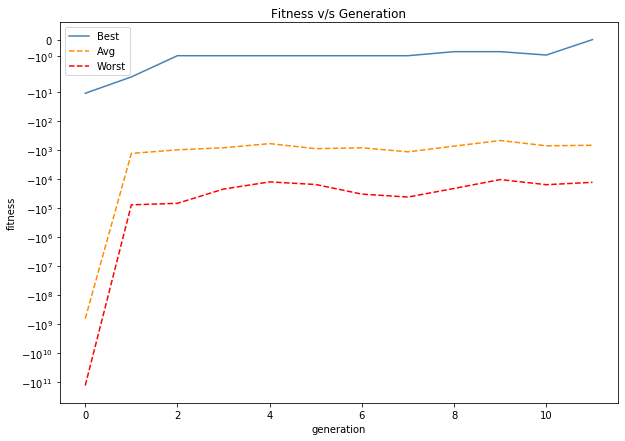

In [5]:
# 'Des chiffres et des lettres' problem 1.

TARGET_NUMBER_1 = 459
terminal_set_1 = [25, 7, 8, 100, 4, 2]
function_set_1 = [AddNode, SubNode, MulNode, DivNode]

def fitness_number_1(an_individual):
    """Fitness function for the 'Des chiffres et des lettres' problem.

    Args:
        an_individual: Individual to calculate the fitness for.
    
    Returns:
        An integer or float with the fitness score.
    """
    result = an_individual.tree.eval()

    return - abs(TARGET_NUMBER_1 - result)

   
def program_factory(terminal_set, function_set, max_depth):
    """Function that creates an individual with a random AST.

    Returns:
        An individual.
    """
    return Individual(terminal_set, function_set, max_depth)


ga_number_1 = GeneticAlgorithm(fitness_number_1, program_factory, max_depth=4, pop_size=200, terminal_set=terminal_set_1, function_set=function_set_1, max_iter=50, termination_condition = lambda f : f == 0, legible_result=True, silent=False, negative_maximization=True, problem_name="des_chiffres_et_des_lettres_1")
ga_number_1.run()

Generation:  0
Best fitness this generation:  -4
Generation:  1
Best fitness this generation:  -18
Generation:  2
Best fitness this generation:  -18
Generation:  3
Best fitness this generation:  -0.966666666666697
Generation:  4
Best fitness this generation:  -1
Generation:  5
Best fitness this generation:  -1.1999999999999318
Generation:  6
Best fitness this generation:  0
Found solution: (((25 * (10 * 1)) + 6) + ((9 + (10 - 3)) + ((9 * 6) * 6)))


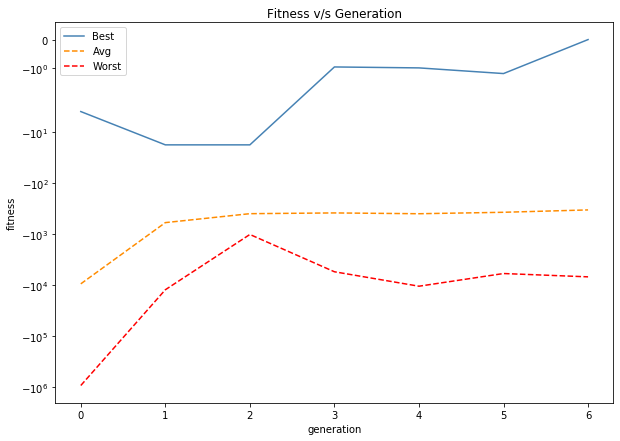

In [6]:
# 'Des chiffres et des lettres' problem 2.

TARGET_NUMBER_2 = 596
terminal_set_2 = [10, 1, 25, 9, 3, 6]
function_set_2 = [AddNode, SubNode, MulNode, DivNode]

def fitness_number_2(an_individual):
    """Fitness function for the 'Des chiffres et des lettres' problem.

    Args:
        an_individual: Individual to calculate the fitness for.
    
    Returns:
        An integer or float with the fitness score.
    """
    result = an_individual.tree.eval()

    return - abs(TARGET_NUMBER_2 - result)

   
def program_factory(terminal_set, function_set, max_depth):
    """Function that creates an individual with a random AST.

    Returns:
        An individual.
    """
    return Individual(terminal_set, function_set, max_depth)


ga_number_2 = GeneticAlgorithm(fitness_number_2, program_factory, max_depth=4, pop_size=200, terminal_set=terminal_set_2, function_set=function_set_2, max_iter=50, termination_condition = lambda f : f == 0, legible_result=True, silent=False, negative_maximization=True, problem_name="des_chiffres_et_des_lettres_2")
ga_number_2.run()

In [7]:
# 'Function that passes through points' problem 1.
# f(x) = ReLU(x)

POINTS_1 = [(-3, 0), (-1, 0), (0, 0), (1, 1), (3, 3)]
terminal_set_3 = [0, 'x']
function_set_3 = [AddNode, SubNode, MulNode, DivNode, MaxNode]

def fitness_points_1(an_individual):
    """Fitness function for the 'Des chiffres et des lettres' problem.

    Args:
        an_individual: Individual to calculate the fitness for.
        round_fitness: Boolean for rounding the fitness to an integer
    
    Returns:
        An integer or float with the fitness score.
    """
    fitness = 0
    for x, y in POINTS_1:
        result = an_individual.tree.eval((x))
        fitness -= (y - result) ** 2
    return fitness

   
def function_factory(terminal_set, function_set, max_depth):
    """Function that creates an individual with a random AST.

    Returns:
        An individual.
    """
    return Individual(terminal_set, function_set, max_depth)


ga_function_1 = GeneticAlgorithm(fitness_points_1, program_factory, max_depth=1, pop_size=100, terminal_set=terminal_set_3, function_set=function_set_3, max_iter=50, termination_condition = lambda f : f >= -0.1, legible_result=True, silent=False, negative_maximization=True, problem_name="points_problem_relu")
ga_function_1.run()

Generation:  0
Best fitness this generation:  0
Found on first generation. No plot generated.
Found solution: (max(0, x))


In [8]:
# 'Function that passes through points' problem 2.
# f(x) = x^3

POINTS_2 = [(-3, -27), (-1, -1), (0, 0), (1, 1), (3, 27)]
terminal_set_4 = ['x']
function_set_4 = [AddNode, SubNode, MulNode, DivNode, MaxNode]

def fitness_points_2(an_individual):
    """Fitness function for the 'Des chiffres et des lettres' problem.

    Args:
        an_individual: Individual to calculate the fitness for.
        round_fitness: Boolean for rounding the fitness to an integer
    
    Returns:
        An integer or float with the fitness score.
    """
    fitness = 0
    for x, y in POINTS_2:
        result = an_individual.tree.eval((x))
        fitness -= (y - result) ** 2
    return fitness

   
def function_factory(terminal_set, function_set, max_depth):
    """Function that creates an individual with a random AST.

    Returns:
        An individual.
    """
    return Individual(terminal_set, function_set, max_depth)


ga_function_2 = GeneticAlgorithm(fitness_points_2, program_factory, max_depth=2, pop_size=100, terminal_set=terminal_set_4, function_set=function_set_4, max_iter=30, termination_condition = lambda f : f >= -0.1, legible_result=True, silent=False, negative_maximization=True, problem_name="points_problem_cubic")
ga_function_2.run()

Generation:  0
Best fitness this generation:  0
Found on first generation. No plot generated.
Found solution: (x * (x * x))


Generation:  0
Best fitness this generation:  -63
Generation:  1
Best fitness this generation:  -28
Generation:  2
Best fitness this generation:  -28
Generation:  3
Best fitness this generation:  0
Found solution: (x + ((x * x) + -3))


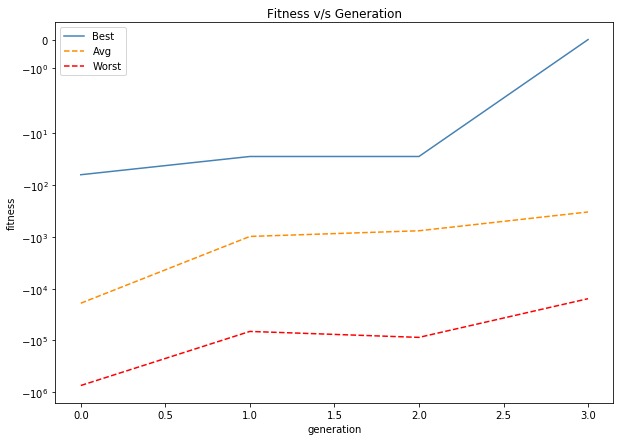

In [9]:
# 'Function that passes through points' problem 3.
# f(x) = x^2 + x - 3

POINTS_3 = [(-3, 3), (-2, -1), (-1, -3), (0, -3), (1, -1), (2, 3), (3, 9)]
terminal_set_5 = [-3, 'x']
function_set_5 = [AddNode, SubNode, MulNode]

def fitness_points_3(an_individual):
    """Fitness function for the 'Des chiffres et des lettres' problem.

    Args:
        an_individual: Individual to calculate the fitness for.
        round_fitness: Boolean for rounding the fitness to an integer
    
    Returns:
        An integer or float with the fitness score.
    """
    fitness = 0
    for x, y in POINTS_3:
        result = an_individual.tree.eval((x))
        fitness -= (y - result) ** 2
    return fitness

   
def function_factory(terminal_set, function_set, max_depth):
    """Function that creates an individual with a random AST.

    Returns:
        An individual.
    """
    return Individual(terminal_set, function_set, max_depth)


ga_function_3 = GeneticAlgorithm(fitness_points_3, program_factory, max_depth=3, pop_size=200, terminal_set=terminal_set_5, function_set=function_set_5, max_iter=50, termination_condition = lambda f : f >= -0.1, legible_result=True, silent=False, negative_maximization=True, problem_name="points_problem_poly")
ga_function_3.run()

Generation:  0
Best fitness this generation:  -455
Generation:  1
Best fitness this generation:  -91
Generation:  2
Best fitness this generation:  -91
Generation:  3
Best fitness this generation:  -91
Generation:  4
Best fitness this generation:  -91
Generation:  5
Best fitness this generation:  -119
Generation:  6
Best fitness this generation:  -119
Generation:  7
Best fitness this generation:  -91
Generation:  8
Best fitness this generation:  -28
Generation:  9
Best fitness this generation:  -28
Generation:  10
Best fitness this generation:  -28
Generation:  11
Best fitness this generation:  0
Found solution: ((x - x) + ((((x * (x * x)) + -3) - (x * x)) + x))


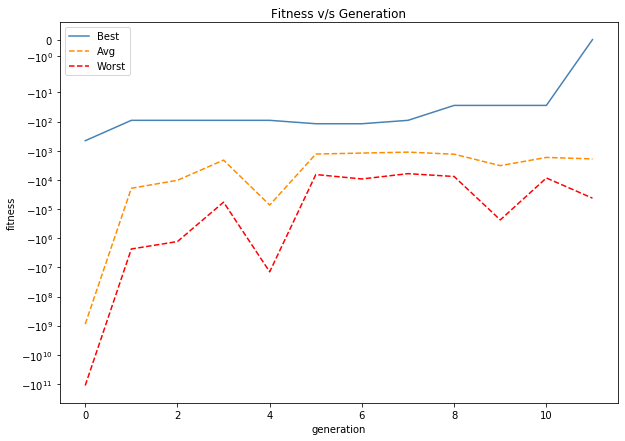

In [10]:
# 'Function that passes through points' problem 4.
# f(x) = x^3 - x^2 + x - 3

POINTS_4 = [(-3, -42), (-2, -17), (-1, -6), (0, -3), (1, -2), (2, 3), (3, 18)]
terminal_set_6 = [-3, 'x']
function_set_6 = [AddNode, SubNode, MulNode]

def fitness_points_4(an_individual):
    """Fitness function for the 'Des chiffres et des lettres' problem.

    Args:
        an_individual: Individual to calculate the fitness for.
        round_fitness: Boolean for rounding the fitness to an integer
    
    Returns:
        An integer or float with the fitness score.
    """
    fitness = 0
    for x, y in POINTS_4:
        result = an_individual.tree.eval((x))
        fitness -= (y - result) ** 2
    return fitness

   
def function_factory(terminal_set, function_set, max_depth):
    """Function that creates an individual with a random AST.

    Returns:
        An individual.
    """
    return Individual(terminal_set, function_set, max_depth)


ga_function_4 = GeneticAlgorithm(fitness_points_4, program_factory, max_depth=6, pop_size=200, terminal_set=terminal_set_6, function_set=function_set_6, max_iter=50, termination_condition = lambda f : f >= -0.1, legible_result=True, silent=False, negative_maximization=True, problem_name="points_problem_4", mutation_rate=0.5, offspring=2)
ga_function_4.run()